# Genre Classification From Lyrics.com
# Data Cleaning

In [136]:
import sqlalchemy
from sqlalchemy import text
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import text, select
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import log

The lyrics.com database is a collection of user-submitted lyric data comprising roughly 1.5 million submissions of song lyrics across a variety of musical genres. This dataset is derived from webscraping the full catalog of lyrics.com and storing the results in a SQLite database. 

There data is split into four relational tables:
1. artists
   - includes data related to artist info such as artist name
2. lyrics
   - includes lyrics as text data as well as song titles and listed publication year
3. genres
   - includes data classifying songs into one or more genres
4. styles
   - includes a subgenre classification of style

In [137]:
from sqlalchemy import create_engine, Table, Column
from sqlalchemy import Integer, String, Text, MetaData

engine = create_engine('sqlite:///../data/raw/lyrics.db', echo=False)

meta = MetaData()

artists = Table('artists', meta,
                Column('artist', String, primary_key=True),
                Column('artist_url', String))

lyrics = Table('lyrics', meta,
               Column('artist', String),
               Column('song_title', String),
               Column('year', Integer),
               Column('song_url', String, primary_key=True),
               Column('lyrics', Text))

genres = Table('genre', meta,
               Column('id', Integer, primary_key=True, autoincrement=True),
               Column('song_url', String),
               Column('genre', String))

styles = Table('style', meta,
               Column('id', Integer, primary_key=True, autoincrement=True),
               Column('song_url', String),
               Column('style', String))

if __name__ == '__main__':
    meta.create_all(engine)


We can set up a schema to access these tables using SQLAlchemy, which is a versatile interface for interacting with databases of all sizes in Python. Here we define each table and the rules for interaction with each of them.

In [138]:
conn = engine.connect()

In [139]:
query = text('SELECT * FROM lyrics')
artists = conn.execute(query).fetchall()
data = pd.DataFrame(artists)
data.columns = ['artist', 'song', 'year', 'url', 'lyric']
data_url = data.copy()
data = data.drop(labels='url', axis=1)

Since the dataset has a large number of tracks without text information, it is able to fit into memory without a great deal of difficulty. We recast the data as a pandas dataframe.

In [140]:
num_rows = data.shape[0]
no_lyr = data.lyric.isna()

print('''
Number of rows:\t\t%s
Number of lyrics:\t%s
''' % (num_rows, no_lyr.sum()))


Number of rows:		1250843
Number of lyrics:	382600



From the lyrics dataframe we can see that we have roughly 1.25 million individual songs to work with, and that 380,000 are lacking lyric data. These tracks are largely instrumental or electronic tracks that feature no lyrical content

# Genre Tagging Completeness

In [141]:
query = """SELECT l.artist, l.song_title, l.year, g.genre, l.lyrics
           FROM lyrics l JOIN genre g ON g.song_url = l.song_url"""
genres = conn.execute(query).fetchall()
genres = pd.DataFrame(genres)
genres.columns = ['artist', 'song_title', 'year', 'genre', 'lyrics']
genres.to_pickle('../data/processed/lyrics_genre.pickle')
print('Genre tagged songs missing lyrics: %s' % (genres.lyrics.isnull().sum()))

Genre tagged songs missing lyrics: 0


Interestingly none of the songs tagged with genre information in the database are missing lyric information.

In [142]:
unique_songs = genres.groupby(['artist','song_title'])
unique_songs.count().shape

(134673, 3)

We can see that looking at unique song titles in the group of songs with a matched genre tag brings our data set down to around 135,000 songs. A huge reduction.

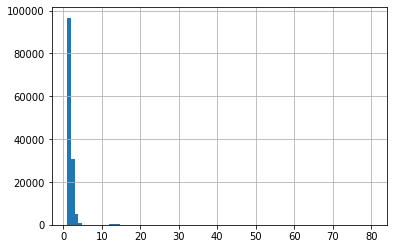

In [143]:
genre_counts = unique_songs.genre.count()
genre_counts.hist(bins=80)
plt.show()

We can see that the vast majority of tracks have a single genre classification, but a subset has from two to 80 tracks.

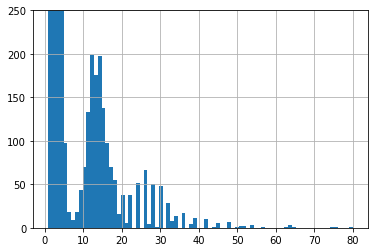

In [144]:
genre_counts.hist(bins=80)
plt.ylim([0,250])
plt.show()

If we focus on the area close below 250 tracks, we can see that there is a multimodal distribution of number of track tags. Some tracks have as many as 80 genres tagged, and there is a strong continuous peak between 10-20 tracks.

In [145]:
print((genre_counts > 1).sum())
print((genre_counts > 2).sum())

38004
7224


Roughly 38000 tracks have multiple genre tags, though the vast majority of these have two genre classifications. If we focus on a subset of genres, we may be able to use some of these tracks by eliminating genre tags we are not focusing on.

In [146]:
genres.genre.value_counts()

Rock                      56226
Pop                       46089
Jazz                      18897
Electronic                17622
Folk, World, & Country    17236
Hip Hop                   14935
Funk / Soul               12355
Latin                      7190
Blues                      5270
Stage & Screen             3512
Reggae                     2853
Classical                   889
genre                       850
Non-Music                   367
Children's                  349
Brass & Military             26
genres                        8
Ce genre de Mec               5
Ce genre                      2
Rapgenre                      2
transgenres                   1
Ce genre Lyrics               1
Le genre féminin              1
 Buy This Song                1
Name: genre, dtype: int64

We can see that there are a subset of genres that are much better represented than others. We will likely have to narrow our group of genres down to two to three genres to focus on. For this first filter, we will subset the data to genres with more than 10,000 tagged songs.

In [147]:
genres_many = ['Rock', 'Pop', 
               'Jazz', 'Electronic', 
               'Folk, World, & Country', 'Hip Hop', 'Funk / Soul']

genres_filtered = genres[genres.genre.isin(genres_many)]

In [148]:
genre_vals = genres_filtered.groupby(['artist','song_title']).genre.apply(list)


We can now look at which genres co-occur with other genres the most.

In [149]:
genres_reduced = genres_filtered[['artist','song_title','genre']]
genres_pivot = genres_reduced.pivot_table('artist', 'song_title', 'genre', aggfunc=len, fill_value=0)
genres_pivot[genres_pivot > 0] = 1

multi_genre = genres_pivot.apply(sum, axis=1) > 1
genres_pivot = genres_pivot[multi_genre]

u = genres_pivot
v = u.T.dot(u)
v.values[[np.arange(v.shape[0])]*2] = 0

v

<ipython-input-149-923467a7fd86>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v.values[[np.arange(v.shape[0])]*2] = 0


genre,Electronic,"Folk, World, & Country",Funk / Soul,Hip Hop,Jazz,Pop,Rock
genre,,,,,,,
Electronic,0,784,1473,1651,598,4093,4202
"Folk, World, & Country",784,0,854,452,822,3027,3232
Funk / Soul,1473,854,0,1096,1156,2719,2246
Hip Hop,1651,452,1096,0,287,1532,1459
Jazz,598,822,1156,287,0,3289,1370
Pop,4093,3027,2719,1532,3289,0,10669
Rock,4202,3232,2246,1459,1370,10669,0


This imposing chunk of code takes our genre lists and creates a pivot table of the co-occurence of each genre. For example, 10,669 Rock songs are also tagged as Pop.

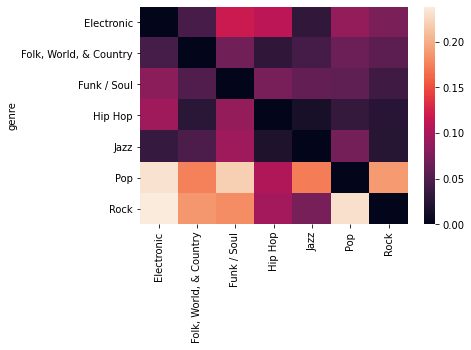

In [150]:
sns.heatmap(v / genres_reduced.genre.value_counts())
plt.show()

This heatmap is normalized by column for the total count of each genre. So for example, the Rock column represents the proportion of all Rock songs that overlap with each other potential genre. The Rock row represents the proportion of every other label that is also classified as Rock.

From this we can see that Rock and Pop are the most promiscuous genres, and that this is especially true between these two groups. Looking crosswise, we can see that virtually every other genre has between 15%-20% of its multilabeled instances labeled as a combination with Rock, and the same is generally true with Pop. Only Jazz and Hip Hop somewhat buck this trend.

This may serve as a reason to exclude one or both of the Pop and Rock genres from classification tasks, as they seem to have less information content than other genre classifications. We will also limit to songs that only have one genre classification.

In [151]:
final_genres = ['Rock','Folk, World, & Country', 'Hip Hop', 'Electronic', 'Jazz', 'Funk / Soul']

genres_final = genres[genres.genre.isin(final_genres)]
is_single = genres_final.groupby(['artist','song_title']).count()
is_single = is_single[is_single.genre > 1]
is_single = is_single.reset_index()

# Create complex key
is_single['complex'] = is_single.artist.astype(str) + is_single.song_title.astype(str)
genres_final['complex'] = genres_final.artist.astype(str) + genres_final.song_title.astype(str)

genres_final = genres_final[~genres_final.complex.isin(is_single.complex)]
genres_final = genres_final.drop('complex', axis=1)

genres_final.genre.value_counts()

<ipython-input-151-e1aa2297243a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_final['complex'] = genres_final.artist.astype(str) + genres_final.song_title.astype(str)


Rock                      41427
Jazz                      14608
Folk, World, & Country    11851
Hip Hop                   10394
Electronic                 9929
Funk / Soul                7244
Name: genre, dtype: int64

For our purposes here, we will exclude the Pop genre from classification in hopes that it will decrease cross-genre classification errors. We also limit to tracks with only one genre tag represented.

# Song Language

In [152]:
from langdetect import detect

result = []
for lyr in tqdm(genres_final.lyrics):
    if len(lyr) >= 50:
        try:
            result.append(detect(lyr[:50]))
        except:
            result.append(detect(lyr[50:]))
    else:
        result.append(detect(lyr))
        
genres_en = genres_final[np.array(result) == 'en']

We can use `langdetect` to classify the language of each track in order to prevent classification errors that may be picking up on imbalances of non-English-language words in each subset.

In [153]:
pd.DataFrame(result).loc[:,0].value_counts()[:10]

en    83692
fr     2126
es     2012
de     1096
it     1060
pt      764
af      686
so      527
nl      470
id      462
Name: 0, dtype: int64

We can see that English comprises the majority of the lyrics in the dataset, with French, Spanish, Dutch, and Italian rounding out the top five. We keep our English lyrics and discard the remaining dataset.

We can detect English language lyrics and limit our data set to that subset.

# NLP Model Feature Conversion

In [154]:
genres_en_sorted = genres_en.copy()
genres_en_sorted['song_title'] = genres_en_sorted['song_title'].str.replace('[^\w\s]','')
genres_en_sorted = genres_en_sorted.sort_values('song_title')

As a short diversion, we can take a look at the remaining song lyrics and compute a couple of interesting statistics in regards to the most common words and phrases in the data.

In [155]:
from nltk.corpus import stopwords
flatten = lambda l: [item for sublist in l for item in sublist]
stopwords = stopwords.words('english')
stop_words = list(set(flatten([i.split("'") for i in stopwords]))) + stopwords

We first supplement the list of stopwords to prevent fragments like "don" and "ll" from appearing in our corpus.

In [156]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stop_words,
                            strip_accents='ascii',
                            max_df=0.60,
                            min_df=0.001)
X = vectorizer.fit_transform(genres_en_sorted.lyrics)

The scikit-learn CountVectorizer can help us look at the most commonly appearing words and phrases in the corpus. We limit the words we consider by frequency so that words appearing in more than 60% of documents or words in fewer than 0.1% of documents will not be included. This is to prevent simple English words which are grammatically overrepresented from predominating the results.

In [157]:
features = pd.DataFrame({'feature': vectorizer.get_feature_names(),
                         'count':X.toarray().sum(axis=0)})
features.sort_values('count', ascending=False)[:10]

,feature,count
3002,love,150050
2766,know,114709
2906,like,113039
2171,got,94280
3451,oh,90780
2095,get,86819
2143,go,70993
259,baby,70908
3463,one,69879
5252,time,65345


We can see that we get quite a few pedestrian words in the output, but we also see a couple of core concepts like time and love rising to the top.

# Duplicate Detection

Because lyrics.com is rife with covers and collaborations, we need to find and eliminate duplicate records in our lyrics database. The following class will do so (though not exhaustively). It iterates through subsets of the data finding duplicate song records defined by cosine similarity between the word vectors. It will retain the earliest version of the song amongst the detected set of duplicates. 

The reason for splitting the dataset into subchunks is the amount of memory required by the similarity matrix. For the full set of 85k rows, the similarity matrix requires over 50 GB of RAM. For this reason we focus on subsets. If a song has a duplicate in another chunk, this method will not find it, though we can run it iteratively in order to find additional matches. In order to maximize the number of matches found, we sort by song title, increasing the chance that similar lyrics will be in the same chunk.

In [158]:
from sklearn.metrics.pairwise import cosine_similarity

class Deduplicator:
    def __init__(self, df, matrix, threshold=0.8, increment=20000):
        self.df = df
        self.matrix = matrix
        self.threshold = threshold
        self.increment = increment
        self.years = df.year.values
        self.tiebreaker = np.array([])
        self.index = np.ones(matrix.shape[0], dtype=bool)
    
    def make_sim_matrix(self, mat):
        '''Make cosine similarity matrix from sparse matrix'''
        similarity = cosine_similarity(mat.toarray())
        np.fill_diagonal(similarity, 0)
        self.similarity = similarity
        
    def check_years(self, ind1, ind2):
        '''Compares two years and returns the indices that should be zeroed out
           which corresponds with the later of the two years'''
        y1, y2 = self.years[ind1], self.years[ind2]
        if y1 == y2:
            if ind1 in self.tiebreaker and ind2 not in self.tiebreaker:
                return ind2
            elif ind2 in self.tiebreaker and ind1 not in self.tiebreaker:
                return ind1
            else:
                self.tiebreaker = np.append(self.tiebreaker, ind1)
                return ind2
        if y1 < y2:
            return ind2
        else:
            return ind1
        
    def deduplicate(self):
        '''iterate through chunks of the data creating similarity matrices
           and eliminating newer versions of old songs'''
        i = 0 # global matrix index
        dup = []
        mat_max = self.matrix.shape[0]
        progress = tqdm(total=mat_max)
        update_amt = self.increment
        while i < mat_max:
            if i + self.increment < mat_max:
                self.make_sim_matrix(self.matrix[i: i + self.increment])
            else:
                self.make_sim_matrix(self.matrix[i: mat_max])
                update_amt = mat_max % i
            dup = np.where(self.similarity > self.threshold)
            for j in range(len(dup[0])):
                ind = self.check_years(dup[0][j], dup[1][j]) + i
                self.index[ind] = False
            i += self.increment
            progress.update(update_amt)


In [159]:
d = Deduplicator(df=genres_en_sorted,
                 matrix=X,
                 increment=20000,
                threshold=0.7)

d.deduplicate()

In [160]:
songs_no_dupes = genres_en_sorted[d.index]
songs_no_dupes.shape

(47846, 5)

In [161]:
X2 = vectorizer.fit_transform(songs_no_dupes.lyrics)
d = Deduplicator(df=songs_no_dupes,
                 matrix=X2,
                 increment=20000,
                threshold=0.7)

d.deduplicate()

In [162]:
songs_no_dupes = songs_no_dupes[d.index]
songs_no_dupes.shape

(47125, 5)

This decreases our training set from 84,000 records to 45,000 records. This sample indicates that almost 45% of the dataset is comprised of duplicate records. This deduplication approach may also catch some edge cases, like songs with placeholder text, songs with very simple lyrics ("lalala"), and popular songs (which are more likely to be those tagged with a genre).

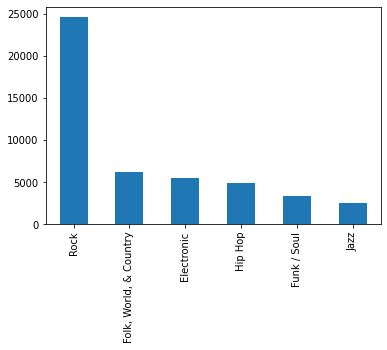

In [163]:
songs_no_dupes.genre.value_counts().plot.bar()

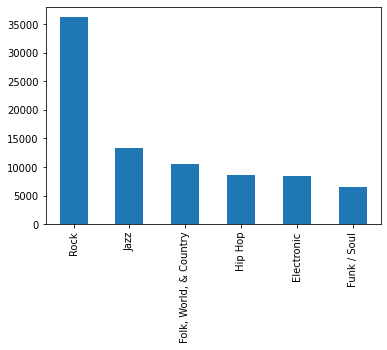

In [164]:
genres_en_sorted.genre.value_counts().plot.bar()

When we look at the before and after plots, we can see that Jazz and Folk were hit the hardest by the deduplication process, while the mix of Rock, Folk, and Electronic remained fairly consistent. 

# Save output files

In [165]:
import pickle

save_path = '../data/processed/'
genres.to_pickle(save_path + 'lyric_genres.pickle')
data.to_pickle(save_path + 'lyric_full.pickle')
songs_no_dupes.to_pickle(save_path + 'lyric_nodupes.pickle')

We pause here to create a checkpoint so that we can restart our analysis from this point if necessary

# Investigation of Cleaned Data

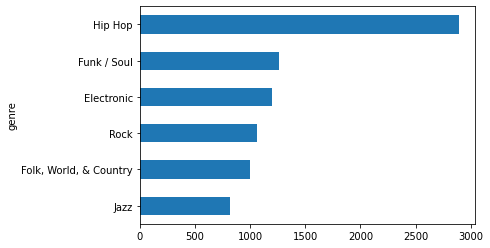

In [166]:
lyrics = pd.read_pickle('../data/processed/lyric_nodupes.pickle')  # New copy just in case we want the other data later
lyrics['song_len'] = lyrics.lyrics.apply(len)
lyrics.groupby('genre').song_len.mean().sort_values().plot.barh()

Taking a look at the average length of a song in characters, it's clear that Rap has the longest average lyrics, with songs containing twice as many characters as the next closest genre. The remaining genres are all relatively close to one another, with Jazz bringing up the rear.

<BarContainer object of 5 artists>

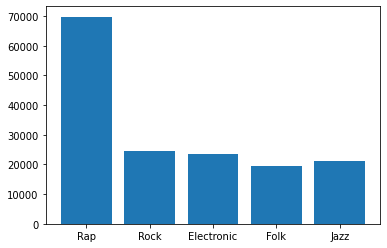

In [167]:
def get_unique_words(genre_name):
    folds = []
    for i in range(10):
        word_set = set()
        genre_subset = lyrics[lyrics.genre == genre_name].sample(2000)
        genre_subset.lyrics.str.rsplit().apply(word_set.update)
        folds.append(len(word_set))
    return np.mean(folds)

rap_words = get_unique_words('Hip Hop')
rock_words = get_unique_words('Rock')
folk_words = get_unique_words('Folk, World, & Country')
elec_words = get_unique_words('Electronic')
jazz_words = get_unique_words('Jazz')

plt.bar(['Rap', 'Rock', 'Electronic', 'Folk', 'Jazz'], 
        [rap_words, elec_words, rock_words, folk_words, jazz_words])

Taking a look at the number of unique words used in each genre has similar results. We bootstrap ten samples of 2000 songs from each genre and look at the average vocabulary size (this is to correct for the huge amount of Rock songs relative to other genres). Rap has the most complex word choice, with nearly four times the number of unique words compared to the other genres. 

Interestingly, here Jazz shows it has slightly more words in its vocabulary than Folk, despite having fewer average characters per song. 

In [168]:
grouped_lyrics = lyrics.groupby('genre').artist.value_counts()
grouped_lyrics.groupby(level=0).nlargest(3)

genre                   genre                   artist            
Electronic              Electronic              Depeche Mode           68
                                                Madonna                57
                                                Pet Shop Boys          44
Folk, World, & Country  Folk, World, & Country  George Jones           98
                                                Johnny Cash            93
                                                Marty Robbins          69
Funk / Soul             Funk / Soul             Aretha Franklin        60
                                                James Brown            52
                                                Stevie Wonder          45
Hip Hop                 Hip Hop                 Nas                    53
                                                Jay-Z                  52
                                                Lil Wayne              44
Jazz                    Jazz                 

We can also take a look and see who the most productive artists are in each one of the subsets, giving us some intuition about the types of music represented by each genre tag. It is interesting to see Depeche Mode as the top Electronic artist, which seems to indicate that Electronic and Rock may be closer than would be assumed. The presence of Madonna may indicate that some artists primarily classed as "Pop" were absorbed into other genres.

In [169]:
print(lyrics.groupby('genre').year.mean())
print(lyrics.groupby('genre').year.median())
print(lyrics.groupby('genre').year.min())

genre
Electronic                2001.370857
Folk, World, & Country    1989.825232
Funk / Soul               1989.770884
Hip Hop                   2002.944730
Jazz                      1988.525293
Rock                      1994.636483
Name: year, dtype: float64
genre
Electronic                2002.0
Folk, World, & Country    1993.0
Funk / Soul               1992.0
Hip Hop                   2002.0
Jazz                      1994.0
Rock                      1997.0
Name: year, dtype: float64
genre
Electronic                1957.0
Folk, World, & Country    1941.0
Funk / Soul               1953.0
Hip Hop                   1969.0
Jazz                      1937.0
Rock                      1952.0
Name: year, dtype: float64


We can also inspect the mean, median, and minimum year within each genre. It is useful to look at both measures in this case since there are competing complications - Jazz and Folk contain several songs which are much older than the other genres, but the number of songs released over time is much larger over time. Still, this gives us some idea of the catalogues: Rap and Electronic music is most contemporary, while Jazz and Folk are the oldest. Rock falls somewhere in between.

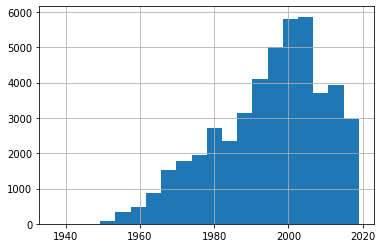

In [170]:
lyrics.year.hist(bins=20)

To validate the assumption that more music is being released over time we can plot a histogram of the number of songs from each year entered into the database. Interestingly, this number seems to have peaked with releases in 2000, then tapered off since that time. We may draw many conclusions from this trend - perhaps Top 40 radio's peak coincided with the peak of culturally pervasive songs, or perhaps there is a 20-year period during which a song becomes classic enough to have the support to find its way onto Lyrics.com.

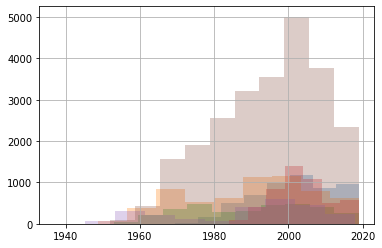

In [171]:
lyrics.groupby("genre").year.hist(alpha=0.3)
plt.show()

A stacked histogram gives us some idea of this trend. Pandas does not provid us with a legend, but we can now see the emergence of Rap and Electronic in the 1980s, and the rise and decline of Jazz and Folk in the 60s.

In [172]:
from wordcloud import WordCloud

def make_wordcloud(text):
    cloud = WordCloud(collocations=False).generate(text)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

We define a convenience function to help making our many word clouds easier.

In [173]:
rock   = lyrics[lyrics.genre == 'Rock'].lyrics.str.cat(sep =' ')
hiphop = lyrics[lyrics.genre == 'Hip Hop'].lyrics.str.cat(sep =' ')
folk   = lyrics[lyrics.genre == 'Folk, World, & Country'].lyrics.str.cat(sep =' ')
electronic   = lyrics[lyrics.genre == 'Electronic'].lyrics.str.cat(sep =' ')
jazz = lyrics[lyrics.genre == 'Jazz'].lyrics.str.cat(sep =' ')

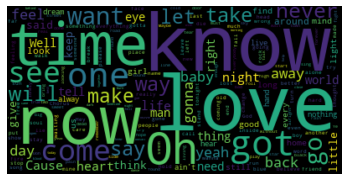

In [174]:
make_wordcloud(rock)

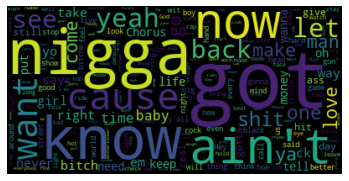

In [175]:
make_wordcloud(hiphop)

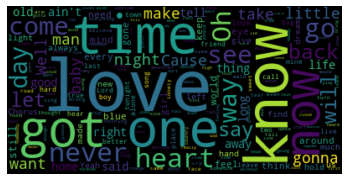

In [176]:
make_wordcloud(folk)

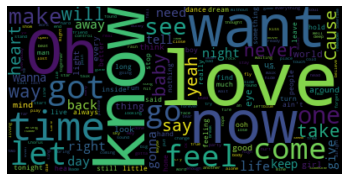

In [177]:
make_wordcloud(electronic)

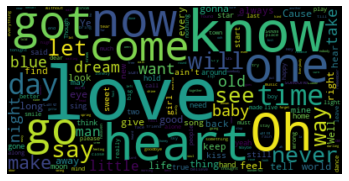

In [178]:
make_wordcloud(jazz)

We can see that the lyrics represented within each one of the genres makes a certain sense with regards to each genre. Folk, Rock, and Electronic look strikingly similar, showing they may be difficult to separate with a classifier. Folk shows some degree of preoccupation with "time", and Rock has a predilection for the word "now". Rap is the only genre without a prominent mention of the word "love". We can also see strong representation of more colloquial language in rap with words like "got", "cause", and "ain't" coming up strong.

# Machine Learning

In [179]:
from sklearn.feature_extraction.text import CountVectorizer

sum_25 = [0]
sum_50 = [0]
sum_100 = [0]

for i in tqdm(range(1,7)):
    cv = CountVectorizer(ngram_range=(i,i))
    X = cv.fit_transform(lyrics.lyrics)
    sum_25.append(np.sum(X.sum(0) > 25))
    sum_50.append(np.sum(X.sum(0) > 50))
    sum_100.append(np.sum(X.sum(0) > 100))

In order to evaluate the benefit of calculating various ngrams, we can take a look at the relative frequency of various amounts of each level. Due to computational constraints, we will be limited to fewer than 5000 tokens. We can first look at the number of common tokens occurring at each ngram level. 

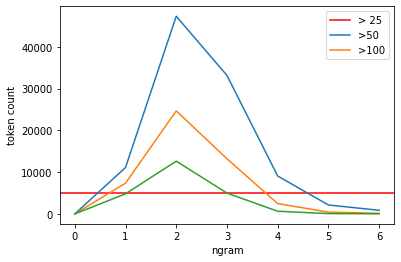

In [180]:
plt.axhline(5000, color='red')

plt.plot(sum_25)
plt.plot(sum_50)
plt.plot(sum_100)

plt.xlabel('ngram')
plt.ylabel('token count')

plt.legend(['> 25', '>50', '>100'])

As we can see, ngrams of 2 words seem to have the most often occurring phrases in the corpus. Since gating by frequency will give us the top common terms, this method is likely to be predominated by ngrams of length 2. With this in mind, it makes sense that we should consider ngrams of less than 4 when training our model, as 4-grams are unlikely to be common enough to meet the TfidVectorizer's feature selection threshold.

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents='ascii',
#                         stop_words=stop_words,
                        ngram_range=(1,3),
#                         max_df=0.8,
                        max_features=1500)

X_tfidf = tfidf.fit_transform(lyrics.lyrics)

Here we apply TF-IDF (Term Frequency Inverse Document Frequency) as a way of transforming our data to emphasize the most conspicuous terms within each set of lyrics. These metrics can be used for clustering to describe the organization of our data.

Interestingly, experimenting with various parameters seems to indicate that the separation between clusters is best captured using a relatively limited set of common words. The addition of stopword filtering actually causes cluster separation to decrease, so these very common terms may represent useful information.

In [182]:
tfidf_array = X_tfidf.toarray()
print(tfidf_array.shape)

(47125, 1500)


In [183]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_array, lyrics.genre, test_size=0.2)

In [184]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []

for i in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tfidf_array)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_test, kmeans.predict(X_test)))

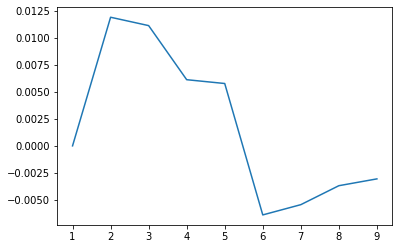

In [185]:
plt.plot(range(1,10), [0] + silhouette)
plt.show()

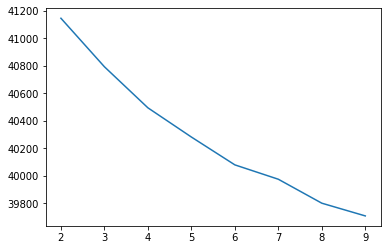

In [186]:
plt.plot(range(2,10), inertia)

Looking at the TF-IDF model, it seems that silhouette scores favor a division into two clusters. However, this clustering is very weak. It's possible that our dataset is too small to achieve good separation, or perhaps no strong delineation between groups is evident based on the data.

DBSCAN and HDBSCAN models were also run on the data, but both failed to identify any spatially oriented subclusters.

# Classification

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer

data_reduced = lyrics[lyrics.genre.isin(['Folk, World, & Country', 
                                         'Hip Hop', 
                                         'Electronic'])]


tfidf_reduced = TfidfVectorizer(strip_accents='ascii',
#                         stop_words=stop_words,
                        ngram_range=(1,3),
#                         max_df=0.8,
                        max_features=1500)

X_tfidf_reduced = tfidf_reduced.fit_transform(data_reduced.lyrics)
tfidf_array_reduced = X_tfidf_reduced.toarray()

Due to these issues, we can observe that something strange seems to be going on with the data. At the very least, any trends related to the genre information of the data set seems not to be detectable in a euclidean clustering framework. Because of this we can try more nonlinear classifiers.

For reasons we'll return to later on in the analysis, we restrict the data set to only three genres for this classification task. We consider roughly 30,000 songs split between the Hip Hop, Folk, and Electronic genres.

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_array_reduced, 
                                                    data_reduced.genre, 
                                                    test_size=0.2)

We first create splits in our data to allow us to have a comparitor for how our classifier performs on data that was not seen during trianing.

In [189]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score, auc, roc_curve
from time import time

def eval_classifier(clf, X_test, y_test, name):
    start = time()
    clf.fit(X_train, y_train)
    clf_time = time() - start
    print(f"Runtime : {clf_time} seconds")
    
    predicted = clf.predict(X_test)
    y_test_arr = y_test.values
    
    accuracy = clf.score(X_test, y_test)
    f1 = np.mean(f1_score(y_test_arr, predicted, average=None))
    precision = np.mean(precision_score(y_test_arr, predicted, average=None))
    recall = np.mean(recall_score(y_test_arr, predicted, average=None))
    
    cm = confusion_matrix(y_test_arr, predicted)
    print(f'Accuracy: {accuracy}')
    print(f'F1 : {f1}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')

    plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_test)
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    return({'name': name, 'runtime': clf_time,'accuracy': accuracy, 
            'f1': f1, 'precision': precision, 'recall': recall})

We also define the above convenience function for evaluating our classifier performance on the data set.

Runtime : 0.1491250991821289 seconds
Accuracy: 0.7524722804914594
F1 : 0.7540687614531542
Precision : 0.7594284616756527
Recall : 0.7509080451782347


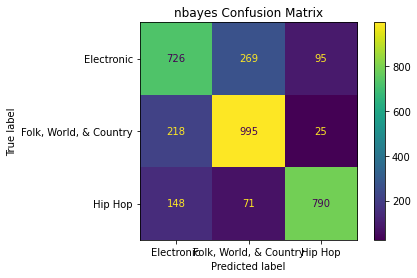

In [190]:
from sklearn.naive_bayes import MultinomialNB

nbayes = MultinomialNB()
nbayes_metrics = eval_classifier(nbayes, X_test, y_test, 'nbayes')

We first try a Naive Bayes classifier, which historically runs quite well on TF-IDF data. This classifier runs lightening fast and out of the box manages to give us 74% accuracy with respectable classifier performance.

Runtime : 2.5443882942199707 seconds
Accuracy: 0.7827389871141744
F1 : 0.786247338817822
Precision : 0.7913107093352107
Recall : 0.7829716869341073


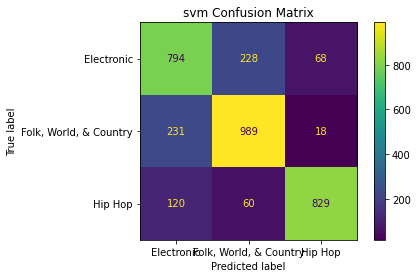

In [191]:
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(loss='hinge', penalty='l2')
svm_metrics = eval_classifier(svm, X_test, y_test, 'svm')

We can also try throwing an SVM classifier at the data. SVMs use mathematical abstraction to deal competently with high dimensional data, and we achieve strong performance across our three classes with respectable compute time.

Runtime : 73.21486902236938 seconds
Accuracy: 0.8037159124962541
F1 : 0.8069706995114038
Precision : 0.8106738013043465
Recall : 0.80432368116925


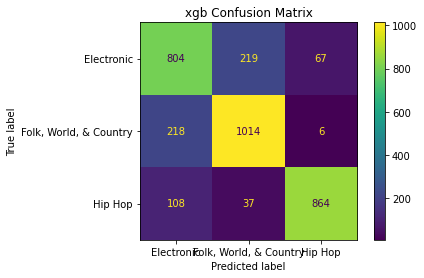

In [192]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb_metrics = eval_classifier(xgb, X_test, y_test, 'xgb')

We can also consider XGBoost as a potential classifier solution. It adds significant overhead for processing time, but we get a decent boost in accuracy as well.

Runtime : 283.163654088974 seconds
Accuracy: 0.7722505244231346
F1 : 0.7745552137631345
Precision : 0.7752840508288336
Recall : 0.7740874471405368


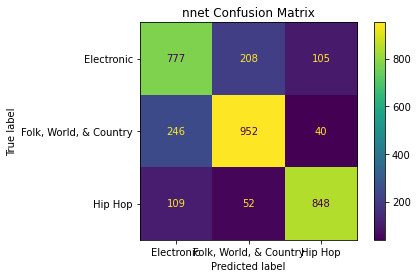

In [193]:
from sklearn.neural_network import MLPClassifier

nnet = MLPClassifier(hidden_layer_sizes=(1500,1500,1500),
                    activation='relu')

nnet_metrics = eval_classifier(nnet, X_test, y_test, 'nnet')

The neural network model adds even more time overhead, but it fails to outperform the XGBoost classifier.

In [194]:
metric_df = pd.DataFrame([nbayes_metrics, 
                          svm_metrics, 
                          xgb_metrics, 
                          nnet_metrics]).set_index('name')
metric_df

,runtime,accuracy,f1,precision,recall
name,,,,,
nbayes,0.149125,0.752472,0.754069,0.759428,0.750908
svm,2.544388,0.782739,0.786247,0.791311,0.782972
xgb,73.214869,0.803716,0.806971,0.810674,0.804324
nnet,283.163654,0.772251,0.774555,0.775284,0.774087


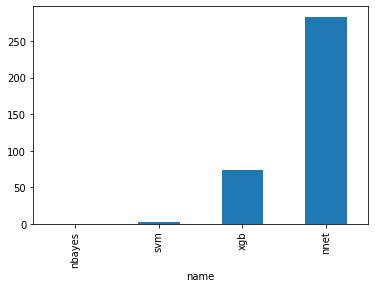

In [195]:
metric_df.runtime.plot.bar()

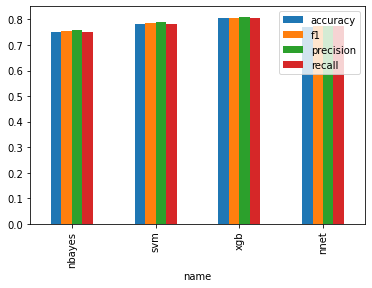

In [196]:
metric_df.drop(['runtime'], axis=1).plot.bar()

With this in mind it seems that the XGBoost model is likely the best tradeoff between performance and speed. However, in cases where a large number of classifications must be performed, the SVM model likely has significant advantages to consider.

In [197]:
# Takes about 20 min to run
from sklearn.model_selection import GridSearchCV

parameters = {'loss': ['hinge', 'log', 'perceptron', 'huber'],  
              'penalty': ['l2', 'l1', 'elasticnet'],
              'alpha': [0.0001, 0.0005, 0.001],
              'max_iter': [500, 750, 1000],
             }
clf = GridSearchCV(SGDClassifier(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.0005, 0.001],
                         'loss': ['hinge', 'log', 'perceptron', 'huber'],
                         'max_iter': [500, 750, 1000],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [198]:
clf.best_params_

{'alpha': 0.0001, 'loss': 'log', 'max_iter': 750, 'penalty': 'elasticnet'}

In [199]:
best_clf = clf.best_estimator_
best_clf.score(X_test, y_test)

0.7854360203775846

Runtime : 56.79115962982178 seconds
Accuracy: 0.613
F1 : 0.611992273173955
Precision : 0.6191926323998111
Recall : 0.606837940824482


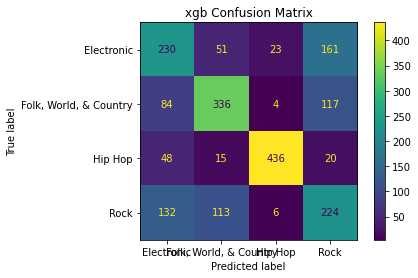

In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer

data_reduced = lyrics[lyrics.genre.isin(['Rock', 
                                         'Folk, World, & Country', 
                                         'Hip Hop', 
                                         'Electronic'])]

data_reduced = data_reduced.groupby('genre').apply(lambda x: x.sample(2500))

tfidf_reduced = TfidfVectorizer(strip_accents='ascii',
                        ngram_range=(1,3),
                        max_features=1500)

X_tfidf_reduced = tfidf_reduced.fit_transform(data_reduced.lyrics)
tfidf_array_reduced = X_tfidf_reduced.toarray()

X_train, X_test, y_train, y_test = train_test_split(tfidf_array_reduced, 
                                                    data_reduced.genre, 
                                                    test_size=0.2)

xgb = XGBClassifier()
xgb_metrics = eval_classifier(xgb, X_test, y_test, 'xgb')

Earlier I commented that we had removed Rock from the classification for a reason. Here we have a rebalanced draw from the data to prevent Rock from being overrepresented. From this result we may see a hint of why clustering was ineffective on the data. Rock appears to be easily misclassified as every genre except for Rap, showing that it shares many traits with these genres. In fact, with the SVM and Naive Bayesian model, this misclassification error is so high that the model largely loses the ability to distinguish all categories other than Hip Hop.

We don't show Funk in this analysis, but it has a similar though lesser trend toward misclassification.

# Conclusions

This analysis is a small sample of what's possible in textual genre classification. It's an even more stark demonstration of how extreme the reduction of data from a scraping set can be. We started with 1.3 million tracks, but ended up with around 20,000 tracks from which to build our classifier. We eliminated roughly 98% of our dataset.

That said, the performance of the SVM and Naive Bayes classifiers on the final dataset is impressive (and fast!). A complicated classifier is not always the most effective - a point that's made even more clear by the fact that the neural network performs almost exactly the same as the SVM even though it takes 300x as long to train.

The failure of clustering coupled with the success of methods that focus on individual word combinations seems to indicate that the decision surface for the genre classes may be highly non-linear or exist in a euclidean space that is different from what can be detected using spatial clustering approaches.

It is also interesting to observe the negative effect that including Rock tracks has on the classification accuracy. Removing Rock increases the ability of the class to classify both Electronic and Folk, suggesting that the two have features independent of one another, both of which are present in Rock. This may indicate that "Rock" is an ineffective classifier, requiring greater granularity in genre labeling.

For additional investigation, it's likely that a larger training set will be required. Approaches using neural-network-based approaches like word-to-vec and LSTM can be extremely informative, but require datasets on the order of 10 to 100 times the size of the annotated portion of this dataset.

All together, this data scarcity reflects why the problem of genre classification is so important for current day efforts in music recommendation and marketing.